# User-Level Analysis of Yelp Reviews (Arizona Restaurants)

### Objective
Analyze user behavior, contributions, and review sentiment for selected business category.

### Approach
1. Join review data with user data
2. Compute metrics
3. Optional: Sentiment analysis of reviews


In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

24/11/24 14:12:41 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/24 14:12:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 14:12:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Reading json files in spark
bizz_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

24/11/24 14:13:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
arizona_businesses_df = spark.read.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet")

In [4]:
arizona_businesses_df.show()

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|8581 N Silverbell Rd|{null, null, u'no...|2tAi411srrpmMofeA...|Coffee & Tea, Bre...|Tucson|{6:30-12:0, 0:0-0...|      1|    32.362689|    -111.120753|Just Breakfast on...|      85743|         113|  3.5|   AZ|
|3655 N Oracle Rd,...|{null, null, null...|kdZr-IdMNOUNZxbZD...|Public Services &...|Tucson|{10:0-17:0, 10:0-...|      1|    32.273139|   -110.9790247|      US 

In [5]:
#Business Schema
bizz_df.printSchema()
bizz_df.show(5)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [6]:
#Checkin Schema
checkin_df.printSchema()
checkin_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
+--------------------+--------------------+
only showing top 5 rows



In [7]:
#Review Schema
review_df.printSchema()
review_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [8]:
#Tip Schema
tip_df.printSchema()
tip_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|

In [9]:
#User Schema
user_df.printSchema()
user_df.show(5)

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

+-------------+---------------+---------------+----------------+-----

In [10]:
# Filter for businesses in the 'Salons' category and ccounting entries
salons_df = arizona_businesses_df.filter(arizona_businesses_df["categories"].contains("Salon"))
rows_count=salons_df.count()
rows_count

554

In [11]:
# Show Salon dataset
salons_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+-----------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|             name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+-----------------+-----------+------------+-----+-----+
|3720 W Ina Rd, St...|{null, null, null...|H-hmY9T6Wv2vV3OTW...|Nail Salons, Beau...|Tucson|{9:0-19:0, 9:0-19...|      1|  32.33825|-111.0447251|        K T Nails|      85741|          69|  3.0|   AZ|
|1519 W Saint Mary...|{null, null, null...|B6I4xLixPsQ1HP8J4...|Nail Salons, Beau...|Tucson|{9:0-19:0, 9:0-19...|      1| 32.228369| -110.996948|    The Jade Nail|      85745|          33|  3.5|  

In [12]:
#Creating Temporary views for all the datasets
salons_df.createOrReplaceTempView("salons")
checkin_df.createOrReplaceTempView("checkin")
review_df.createOrReplaceTempView("review")
tip_df.createOrReplaceTempView("tip")
user_df.createOrReplaceTempView("user")

In [13]:
# View User dataset
spark.sql("""
SELECT * from user limit 10
""").show(truncate=False)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+-----------------------------------------------------------------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
#QUERY 1- General analysis of Yelp users
spark.sql("""
SELECT 
    user_id, 
    name,
    LENGTH(friends) - LENGTH(REPLACE(friends, ',', '')) + 1 AS friend_count,
    fans,
    LENGTH(elite) - LENGTH(REPLACE(elite, ',', '')) + 1 AS prime_customer_in_Yrs
FROM 
    user
where 
LENGTH(friends) - LENGTH(REPLACE(friends, ',', '')) + 1 > 1000
    and
fans >1000
ORDER BY 
    friend_count DESC, fans DESC;
""").show()

+--------------------+------------+------------+----+---------------------+
|             user_id|        name|friend_count|fans|prime_customer_in_Yrs|
+--------------------+------------+------------+----+---------------------+
|iLjMdZi0Tm7DQxX1C...|       Ruggy|       12395|2547|                   15|
|ZIOCmdFaMIF56FR-n...|       Randy|       11026|1124|                   12|
|hizGc5W1tBHPghM5Y...|       Katie|        9390|3642|                   14|
|IU86PZPgTDCFwJEuA...|       Danny|        9217|1409|                   14|
|djxnI8Ux8ZYQJhiOQ...|        Abby|        8858|1806|                   14|
|wEE-YMx5pmSuagLtN...|   Stephanie|        8087|1761|                   14|
|fgwI3rYHOv1ipfVfC...|         Emi|        8028|2424|                   14|
|IDVFG1pNSHIHoVuoL...|        Andy|        7588|1377|                    3|
|UsXqCXRZwSCSw0AT7...|        Carl|        7413|2290|                   11|
|Ve0LUwcrzxL7w0RYg...|        Katy|        7403|1118|                    8|
|VHdY6oG2JPV

In [15]:
# QUERY 2 - Analysis user activity on Yelp
spark.sql("""
SELECT 
    user_id, 
    name,
    EXTRACT(YEAR from yelping_since) as user_on_yelp_since,
    review_count,
    average_stars,
    u.user_id, u.name,
    (u.fans + u.compliment_cool + u.compliment_funny + u.compliment_writer) AS influence_score 
FROM 
    user u
where EXTRACT(YEAR from yelping_since)>2014
          and review_count >100
          and average_stars > 4
order by user_on_yelp_since, review_count, average_stars
""").show()

+--------------------+-------+------------------+------------+-------------+--------------------+-------+---------------+
|             user_id|   name|user_on_yelp_since|review_count|average_stars|             user_id|   name|influence_score|
+--------------------+-------+------------------+------------+-------------+--------------------+-------+---------------+
|y8MdCj6j93xeTm_Ml...| Gerrit|              2015|         101|         4.03|y8MdCj6j93xeTm_Ml...| Gerrit|             18|
|6AaCuTLKjQqAl7Q0M...| Alisha|              2015|         101|         4.08|6AaCuTLKjQqAl7Q0M...| Alisha|             64|
|Ba4teI97GGKyYo6jN...|Michele|              2015|         101|         4.09|Ba4teI97GGKyYo6jN...|Michele|             14|
|cz0c35tpH2htxUmzq...|    Amy|              2015|         101|         4.09|cz0c35tpH2htxUmzq...|    Amy|             44|
|S6pZTpQwLMuzD_Tqi...|   Neil|              2015|         101|         4.09|S6pZTpQwLMuzD_Tqi...|   Neil|             10|
|uiQlMRbEXBn5J1trS...|  

In [16]:
#QUERY 3 - Understanding the activity of elite users on Yelp
#Analyze the total reviews and tips provided by elite users.
spark.sql("""SELECT 
    user_id, 
    name, 
    review_count, 
    (SELECT COUNT(*) FROM tip WHERE tip.user_id = user.user_id) AS total_tips
FROM 
    user
WHERE 
    elite IS NOT NULL
ORDER BY 
    review_count DESC;
""").show()


+--------------------+--------+------------+----------+
|             user_id|    name|review_count|total_tips|
+--------------------+--------+------------+----------+
|Hi10sGSZNxQH3NLyW...|     Fox|       17473|        21|
|8k3aO-mPeyhbR5HUu...|  Victor|       16978|         0|
|hWDybu_KvYLSdEFzG...|   Bruce|       16567|        10|
|RtGqdDBvvBCjcu5dU...|   Shila|       12868|         0|
|P5bUL3Engv-2z6kKo...|     Kim|        9941|         0|
|nmdkHL2JKFx55T3nq...|  Nijole|        8363|         0|
|bQCHF5rn5lMI9c5kE...| Vincent|        8354|         1|
|8RcEwGrFIgkt9WQ35...|  George|        7738|        35|
|Xwnf20FKuikiHcSpc...| Kenneth|        6766|         1|
|CxDOIDnH8gp9KXzpB...|Jennifer|        6679|        24|
|IucvvxdQXXhjQ4z6O...|   Sunil|        6459|        10|
|HFECrzYDpgbS5EmTB...|    Eric|        5887|         0|
|m07sy7eLtOjVdZ8oN...|      Ed|        5800|        51|
|kS1MQHYwIfD0462PE...|     Rob|        5511|         0|
|IlGYj_XAMG3v75rfm...| Dominik|        5434|    

In [17]:
#QUERY 4 - calculate the daily count of new users based on the yelping_since column. 
#Also, compute a rolling 30-day mean.
query="""
WITH daily_counts AS (
    SELECT 
        TO_DATE(yelping_since) AS date,
        COUNT(user_id) AS daily_count
    FROM user
    GROUP BY TO_DATE(yelping_since)
),
rolling_avg AS (
    SELECT 
        date,
        daily_count,
        AVG(daily_count) OVER (
            ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
        ) AS rolling_mean_30d
    FROM daily_counts
)
SELECT * FROM rolling_avg
ORDER BY date;
"""

result_df = spark.sql(query)
result_df.show()

24/11/24 14:19:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:19:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:19:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:19:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:19:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:19:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 1

+----------+-----------+------------------+
|      date|daily_count|  rolling_mean_30d|
+----------+-----------+------------------+
|2004-10-12|         12|              12.0|
|2004-10-13|          5|               8.5|
|2004-10-14|          6| 7.666666666666667|
|2004-10-15|         14|              9.25|
|2004-10-16|          2|               7.8|
|2004-10-17|          2| 6.833333333333333|
|2004-10-18|          4| 6.428571428571429|
|2004-10-19|          2|             5.875|
|2004-10-20|          2| 5.444444444444445|
|2004-10-22|          2|               5.1|
|2004-10-24|          1|4.7272727272727275|
|2004-10-29|          1| 4.416666666666667|
|2004-11-01|          1| 4.153846153846154|
|2004-11-02|          1|3.9285714285714284|
|2004-11-03|          1|3.7333333333333334|
|2004-11-05|          2|             3.625|
|2004-11-07|          1|3.4705882352941178|
|2004-11-09|          1|3.3333333333333335|
|2004-11-10|          1| 3.210526315789474|
|2004-11-11|          1|        

24/11/24 14:19:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:19:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/tmp/ipyke

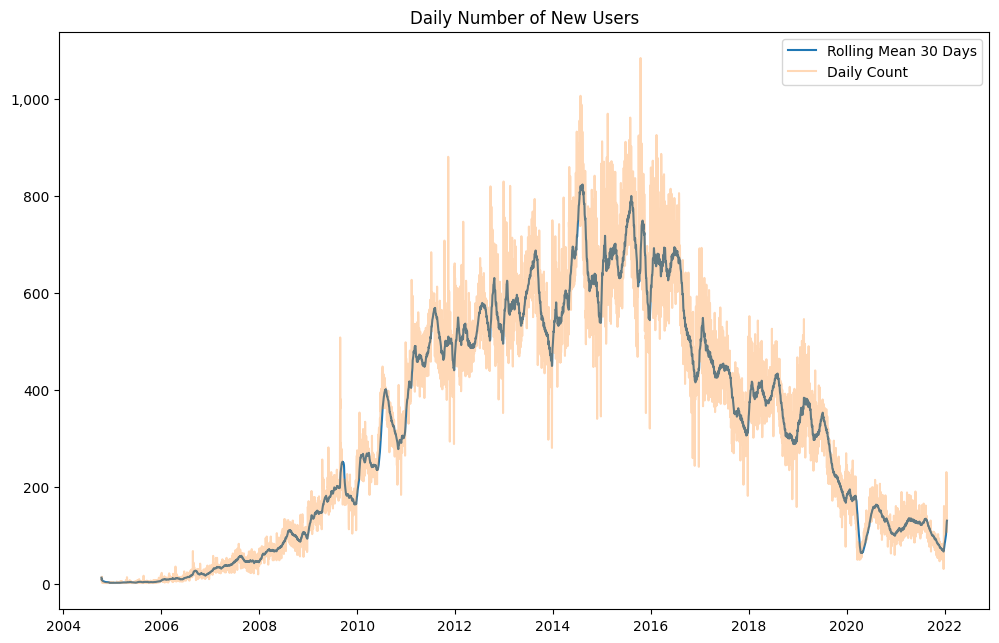

In [18]:
# Graph of Daily number of users joining Yelp as well as the rolling mean of 30 days
import matplotlib.pyplot as plt

result_pd = result_df.toPandas()
fig, ax = plt.subplots(figsize=(12, 7.5))
ax.plot(result_pd['date'], result_pd['rolling_mean_30d'], label='Rolling Mean 30 Days')
ax.plot(result_pd['date'], result_pd['daily_count'], alpha=0.3, label='Daily Count')
ax.set_title('Daily Number of New Users')
ax.legend()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
plt.show()

In [19]:
#QUERY 5 - To group reviews by date and compute the rolling mean for the daily review counts.
query= """
WITH daily_counts AS (
    SELECT 
        TO_DATE(date) AS review_date,
        COUNT(review_id) AS daily_count
    FROM review
    GROUP BY TO_DATE(date)
),
rolling_avg AS (
    SELECT 
        review_date,
        daily_count,
        AVG(daily_count) OVER (
            ORDER BY review_date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
        ) AS rolling_mean_30d
    FROM daily_counts
)
SELECT * FROM rolling_avg
ORDER BY review_date;
"""

review_result_df = spark.sql(query)
review_result_df.show()

24/11/24 14:20:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------+-----------+------------------+
|review_date|daily_count|  rolling_mean_30d|
+-----------+-----------+------------------+
| 2005-02-16|          3|               3.0|
| 2005-03-01|          7|               5.0|
| 2005-03-02|          2|               4.0|
| 2005-03-04|          4|               4.0|
| 2005-03-08|          5|               4.2|
| 2005-03-09|         12|               5.5|
| 2005-03-10|          9|               6.0|
| 2005-03-12|          4|              5.75|
| 2005-03-14|          6| 5.777777777777778|
| 2005-03-15|          3|               5.5|
| 2005-03-16|          5| 5.454545454545454|
| 2005-03-18|          1| 5.083333333333333|
| 2005-03-21|          4|               5.0|
| 2005-03-22|          6| 5.071428571428571|
| 2005-03-25|          1|               4.8|
| 2005-03-29|          3|            4.6875|
| 2005-03-31|          2| 4.529411764705882|
| 2005-04-01|          1| 4.333333333333333|
| 2005-04-03|          3|4.2631578947368425|
| 2005-04-

24/11/24 14:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/11/24 14:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/11/24 14:21:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:21:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:21:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/24 14:21:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/tmp/ipykernel_4742/3582851965.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])


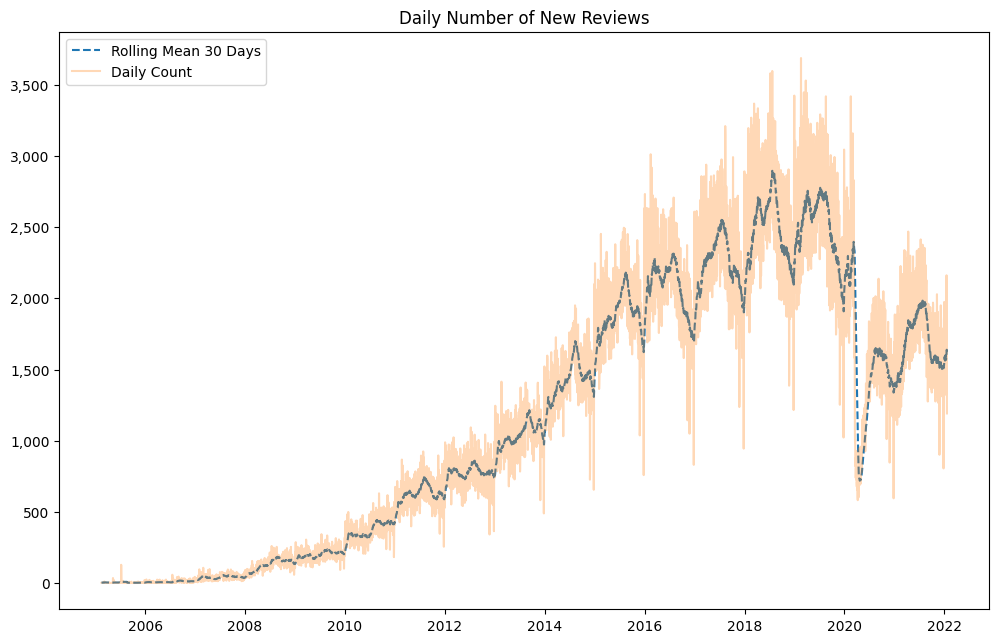

In [20]:
#Plotting the graph
import matplotlib.pyplot as plt

review_result_pd = review_result_df.toPandas()
fig, ax = plt.subplots(figsize=(12, 7.5))
ax.plot(review_result_pd['review_date'], review_result_pd['rolling_mean_30d'], linestyle='--', label='Rolling Mean 30 Days')
ax.plot(review_result_pd['review_date'], review_result_pd['daily_count'], alpha=0.3, label='Daily Count')
ax.set_title('Daily Number of New Reviews')
ax.legend()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
plt.show()


In [22]:
# QUERY 6 - Relation between number of reviews and review count
review_dist_df = spark.sql("""
    SELECT 
        CASE 
            WHEN review_count BETWEEN 1 AND 10 THEN '1-10 Reviews'
            WHEN review_count BETWEEN 11 AND 50 THEN '11-50 Reviews'
            WHEN review_count > 50 THEN '> 50 Reviews'
            ELSE 'No Reviews'
        END AS review_range,
        COUNT(user_id) AS user_count
    FROM user
    GROUP BY review_range
    ORDER BY user_count DESC
""").toPandas()


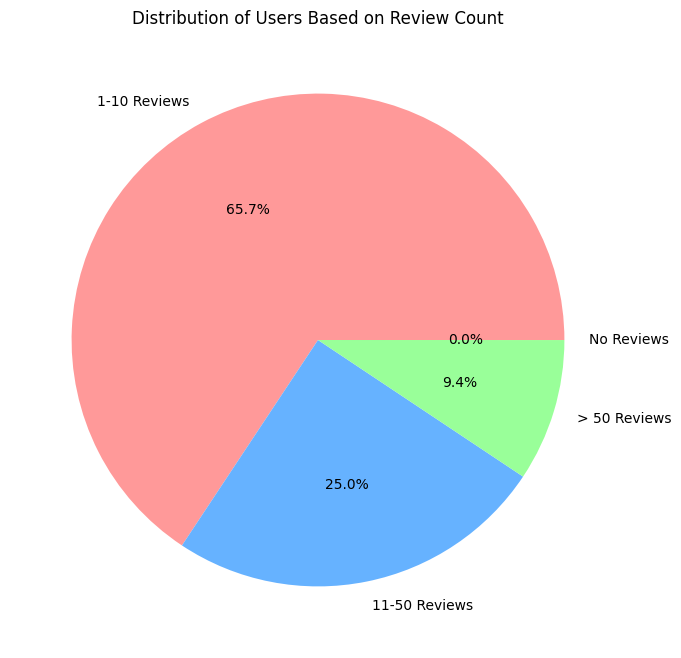

In [23]:
#Plotting the pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(
    review_dist_df['user_count'], 
    labels=review_dist_df['review_range'], 
    autopct='%1.1f%%', 
    colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
)

plt.title('Distribution of Users Based on Review Count')
plt.show()


In [24]:
#pip install textblob

In [25]:
#Performing sentiment analysis of tip's text column and adding it to DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from textblob import TextBlob  # Example library for sentiment analysis

def compute_sentiment(text):
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity     # -1 to 1 range
    return sentiment

sentiment_udf = udf(compute_sentiment, FloatType())
# Add a sentiment score column to the `tips` DataFrame
tip_df = tip_df.withColumn("sentiment_score", sentiment_udf(tip_df["text"]))

In [26]:
#Updated tip_df and creating temporary view
tip_df.createOrReplaceTempView("tip")
spark.sql(""" select * from tip limit 10""").show()

+--------------------+----------------+-------------------+--------------------+--------------------+---------------+
|         business_id|compliment_count|               date|                text|             user_id|sentiment_score|
+--------------------+----------------+-------------------+--------------------+--------------------+---------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|            0.0|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|            0.7|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|            0.0|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|    -0.19166666|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|ld0AperBXk1h6Ubqm...|     0.35714287|
|7Rm9Ba50bw23KTA8R...|               0|2012-03-13 04:00:

In [27]:
# QUERY 7 - Understanding User behaviour as per postal code area 
# on the basis of average rating and median of tip(sentiment analysis)
spark.sql("""
WITH tip_sentiments AS (
    SELECT 
        s.postal_code,
        median(t.sentiment_score) AS median_sentiment
    FROM 
        salons s
    JOIN 
        tip t
    ON 
        s.business_id = t.business_id
    WHERE 
        s.is_open = 1
    GROUP BY 
        s.postal_code
)
SELECT 
    s.postal_code, 
    SUM(s.review_count) AS customers, 
    COUNT(*) AS salon, 
    ROUND(SUM(s.review_count) / COUNT(*), 0) AS customer_per_salon,
    ROUND(AVG(s.stars), 2) AS avg_rating,
    ROUND(ts.median_sentiment, 2) AS median_tip_sentiment
FROM 
    salons s
LEFT JOIN 
    tip_sentiments ts
ON 
    s.postal_code = ts.postal_code
WHERE 
    s.is_open = 1
GROUP BY 
    s.postal_code, ts.median_sentiment
ORDER BY 
     median_tip_sentiment DESC
""").show()

+-----------+---------+-----+------------------+----------+--------------------+
|postal_code|customers|salon|customer_per_salon|avg_rating|median_tip_sentiment|
+-----------+---------+-----+------------------+----------+--------------------+
|      85739|       92|    3|              31.0|       4.0|                0.79|
|      85749|      128|    6|              21.0|      3.33|                0.65|
|      85629|       65|    2|              33.0|      2.75|                 0.6|
|      85755|       60|    4|              15.0|      3.63|                0.59|
|      85714|      162|    7|              23.0|      3.71|                0.57|
|      85737|      516|   16|              32.0|      3.88|                0.56|
|      85658|      107|    3|              36.0|       3.5|                0.53|
|      85715|      323|   18|              18.0|      4.17|                0.52|
|      85748|      519|   12|              43.0|      3.54|                 0.5|
|      85730|      322|   11

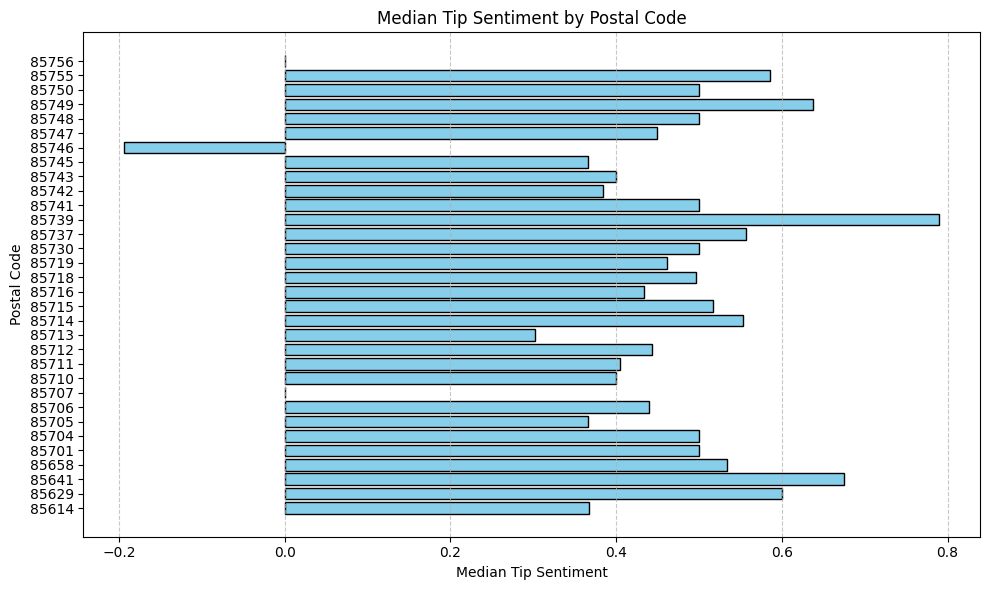

In [28]:
#Plot of Sentiment Score of tip as per postal code.
import matplotlib.pyplot as plt
import pandas as pd

merged_df = tip_df.join(salons_df.select('business_id', 'postal_code'), on='business_id', how='inner')
merged_df_pd = merged_df.toPandas()
median_sentiment = merged_df_pd.groupby("postal_code")["sentiment_score"].median()

plt.figure(figsize=(10, 6))
plt.barh(median_sentiment.index, median_sentiment.values, color="skyblue", edgecolor="black")
plt.xlabel("Median Tip Sentiment")
plt.ylabel("Postal Code")
plt.title("Median Tip Sentiment by Postal Code")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
#QUERY 8 - Senntimeent analysis off user reviews
sentiment_df = spark.sql("""
    SELECT 
        u.user_id, 
        u.name, 
        COUNT(CASE WHEN r.stars >= 4 THEN 1 END) AS positive_reviews,
        COUNT(CASE WHEN r.stars = 3 THEN 1 END) AS neutral_reviews,
        COUNT(CASE WHEN r.stars <= 2 THEN 1 END) AS negative_reviews
    FROM review r
    JOIN user u ON r.user_id = u.user_id
    GROUP BY u.user_id, u.name
    ORDER BY positive_reviews DESC
    LIMIT 10
""").toPandas()


24/11/24 14:41:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 14:41:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 14:41:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 14:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 14:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


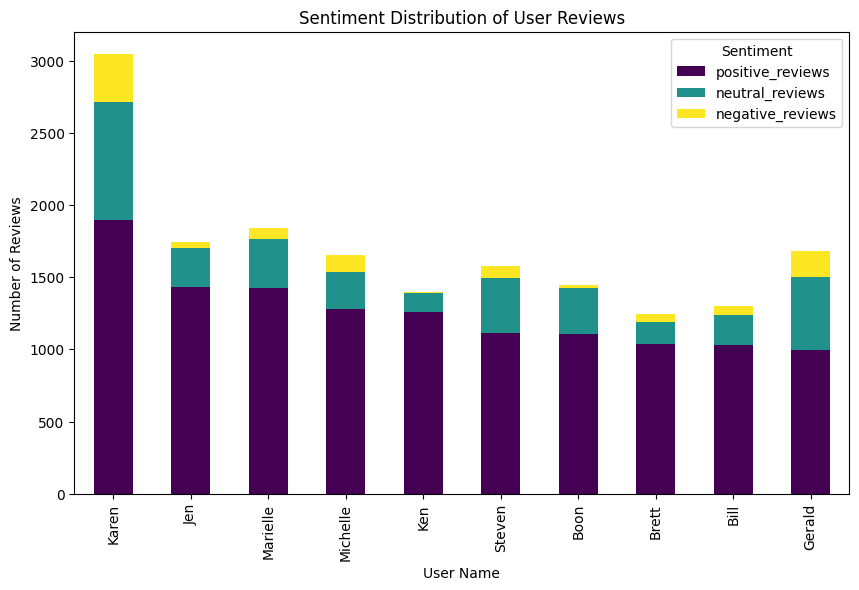

In [32]:
import matplotlib.pyplot as plt

sentiment_df.set_index('name')[['positive_reviews', 'neutral_reviews', 'negative_reviews']].plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    colormap='viridis'
)

plt.xlabel('User Name')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution of User Reviews')
plt.legend(title='Sentiment')
plt.show()


In [33]:
# QUERY 9 - Top 10 Users with the Most Tips Given and Their Average Sentiment Score
top_users_tips_sentiment_df = spark.sql("""
    SELECT 
        u.user_id, 
        u.name, 
        COUNT(t.text) AS total_tips,
        ROUND(AVG(t.sentiment_score), 2) AS avg_sentiment_score
    FROM tip t
    JOIN user u ON t.user_id = u.user_id
    GROUP BY u.user_id, u.name
    ORDER BY total_tips DESC
    LIMIT 10
""").toPandas()


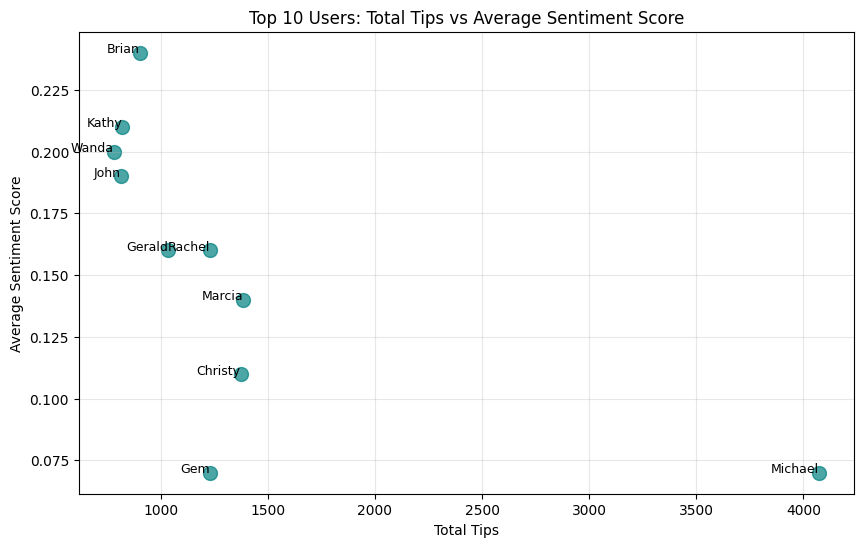

In [34]:
# QUERY 9 - # Scatter plot of total tips vs average sentiment score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    top_users_tips_sentiment_df['total_tips'], 
    top_users_tips_sentiment_df['avg_sentiment_score'], 
    color='teal', 
    alpha=0.7, 
    s=100
)

for i, row in top_users_tips_sentiment_df.iterrows():
    plt.text(row['total_tips'], row['avg_sentiment_score'], row['name'], fontsize=9, ha='right')

plt.title('Top 10 Users: Total Tips vs Average Sentiment Score')
plt.xlabel('Total Tips')
plt.ylabel('Average Sentiment Score')
plt.grid(alpha=0.3)
plt.show()


In [47]:
# QUERY 10 - Distribution of Elite Users by Year
elite_user_distribution_df=spark.sql("""
    SELECT 
        CAST(elite_year AS INT) AS elite_year,
        COUNT(user_id) AS user_count
    FROM (
        SELECT 
            user_id,
            EXPLODE(SPLIT(elite, ',')) AS elite_year
        FROM user
        WHERE elite IS NOT NULL AND elite != '' 
    ) exploded_data
          where  CAST(elite_year AS INT)>2010
    GROUP BY elite_year
    ORDER BY elite_year ASC
""")
elite_user_distribution_df.show()

+----------+----------+
|elite_year|user_count|
+----------+----------+
|      2011|     10997|
|      2012|     15222|
|      2013|     16193|
|      2014|     18571|
|      2015|     24175|
|      2016|     29636|
|      2017|     36015|
|      2018|     41009|
|      2019|     44044|
|      2021|     44542|
+----------+----------+

